In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import cv2
import tqdm

import sys
sys.path.append("../src")

import util

import pandas as pd
import numpy as np
import ast
import torch

In [3]:
model_version = "0119_fastrcnn_pretrain_f4"
model_folder = Path(f"../output/{model_version}/")
params_path = model_folder / "config" / "params.yaml"
params = util.load_yaml(params_path)
params

{'batch': 10,
 'cfg_dir': '/home/vincent/Kaggle/Kaggle_TGBR/output/0119_fastrcnn_pretrain_f4/config',
 'ckpt_path': '/home/vincent/Kaggle/Kaggle_TGBR/output/0119_fastrcnn_pretrain_f4/TGBR/0119_fastrcnn_pretrain_f4/weights/best.pt',
 'copy_image': False,
 'cv_split': 'custom',
 'data_path': '/home/vincent/Kaggle/data/tensorflow-great-barrier-reef',
 'debug': False,
 'device': '',
 'epochs': 15,
 'exp_name': '0119_fastrcnn_pretrain_f4',
 'fold': [4],
 'hyp_file': '/home/vincent/Kaggle/Kaggle_TGBR/output/0119_fastrcnn_pretrain_f4/config/hyp.yaml',
 'hyp_name': 'FasterRCNN_Pretrain',
 'hyp_param': {'base_file': 'mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py',
  'load_from': 'mmdetection/checkpoints/faster_rcnn_r50_fpn_mstrain_3x_coco_20210524_110822-e10bd31c.pth',
  'model_type': 'faster_rcnn'},
 'image_dir': '/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images',
 'img_size': 1280,
 'label_dir': '/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/labels',
 

In [15]:
for key, value in params.items():
    if "file" in key or "dir" in key or "path" in key:
        params[key] = Path(value)

In [18]:
from glob import glob
ckp = glob(str(params['output_dir']) + "/" + "best*")[0]
params['ckpt_path'] = ckp
params['ckpt_path']

'/home/vincent/Kaggle/Kaggle_TGBR/output/0119_fastrcnn_pretrain_f4/best_bbox_mAP_epoch_5.pth'

In [19]:
from mmdet.apis import init_detector, inference_detector

In [21]:
model = init_detector(str(params['cfg_dir'] / "config.py"), ckp, device='cuda:0')

load checkpoint from local path: /home/vincent/Kaggle/Kaggle_TGBR/output/0119_fastrcnn_pretrain_f4/best_bbox_mAP_epoch_5.pth


In [1]:
import mmdet

In [7]:
from mmdet.datasets import CocoDataset

In [9]:
??CocoDataset

In [ ]:
# TODO: add evaluation here  
# if params["tools"] == "mmdetection":
#     logging.info("Inference")
#     from mmdet.apis import init_detector, inference_detector, show_result_pyplot1   
#     from glob import glob
#     from tqdm import tqdm
#     import cv2
#     ckp = glob.glob(str(params['output_dir']) + "/" + "best*")[0]
#     model = init_detector(str(params['cfg_dir'] / "config.py"), ckp, device='cuda:0')
#     valid_df.reset_index(drop=True, inplace=True)
#     prd_bboxs_list = []
#     for idx in tqdm(range(len(valid_df))):
#         row = valid_df.loc[idx]
#         img_path = row["image_path"]
#         result = inference_detector(model, img_path)
#         pred_bbox = result[0][:4]
#         pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
#         pred_confs = result[0][4]
#         valid_df.at[idx, "pred_bbox"] = pred_bbox.tolist()
#         valid_df.at[idx, "pred_confs"] = pred_confs.tolist()
#     valid_df.to_csv(params['output_dir'] / "valid.csv")

In [22]:
home_dir = Path("/home/vincent/Kaggle/Kaggle_TGBR/output/")
data_dir = Path("/home/vincent/Kaggle/data/tensorflow-great-barrier-reef")

In [23]:
df = pd.read_csv(params["root_dir"] / 'train.csv')
df = df.apply(lambda x: util.get_path(x, params, infer=True), axis=1)
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
df['num_bbox'] = df['annotations'].apply(lambda x: len(x))
util.seed_torch(params["seed"])    
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255)) for idx in range(1)]    

In [24]:
folds = pd.read_csv("../input/train_folds_balanced.csv")
df = pd.merge(df, folds[["video_id","video_frame","fold"]], on=["video_id",'video_frame'])
df = df.query("fold != -1")
df_oof = df.query("fold == 4").copy()

In [10]:
# params["repo"] = "./yolov5"
# params["run_test"] = False
# params["augment"]  = False
# params["conf"] = 0.15
# params["iou"] = 0.5

In [26]:
idx = 0

row = df_oof_pos_sample.iloc[idx]
path = row["image_path"]
result = inference_detector(model, path)

/home/vincent/miniconda3/envs/openmmlab/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [41]:
df_oof["pred_bbox"] = None
df_oof["pred_confs"] = None
df_oof_pos_sample = df_oof.query("num_bbox > 0").sample(10)

predict training data


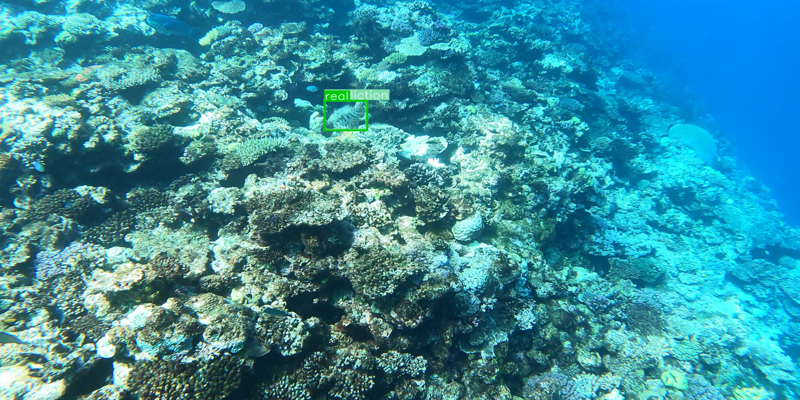

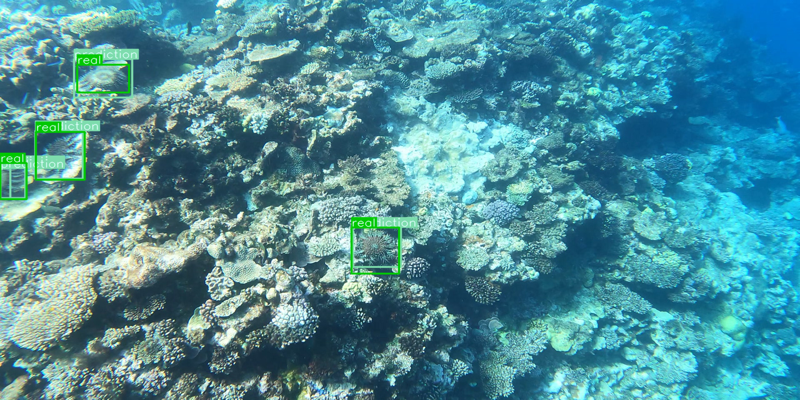

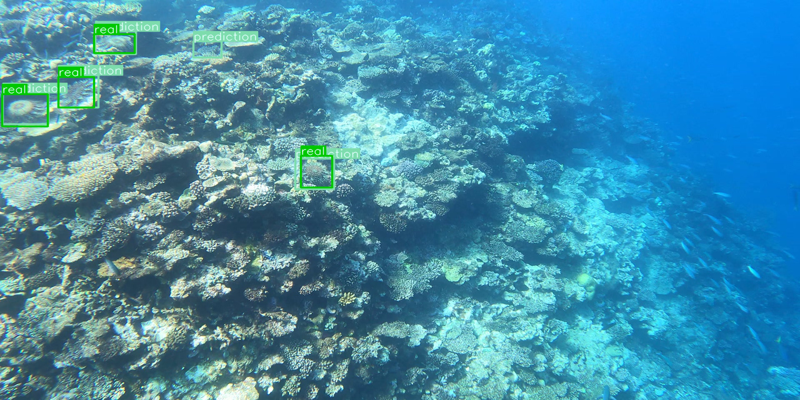

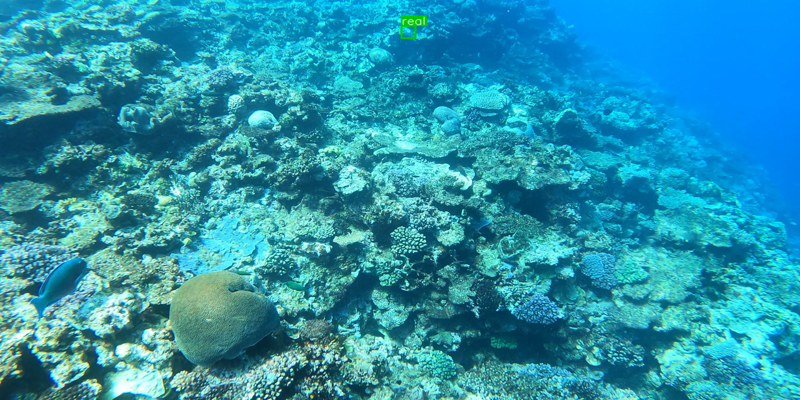

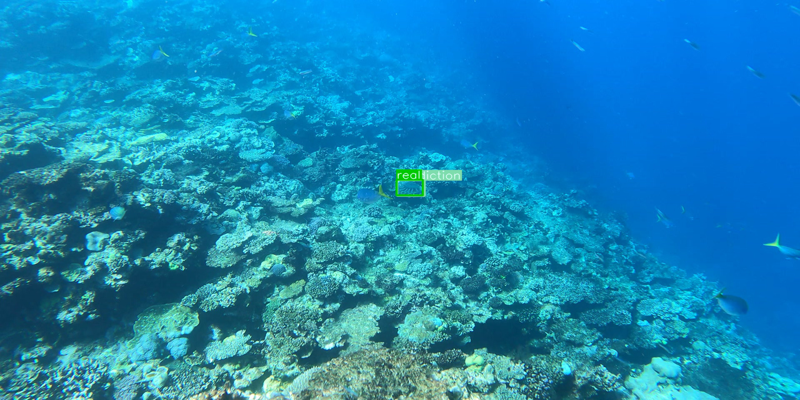

In [42]:
print("predict training data")
color_real = [(0,200,0)]
for idx in range(5):
    row = df_oof_pos_sample.iloc[idx]
    index = row.index
    path = row["image_path"]
    result = inference_detector(model, path)
    pred_bbox = result[0][:,:4]
    pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
    pred_confs = result[0][:,4]
    #df_oof_pos_sample.at[index, "pred_bbox"] = pred_bbox.tolist()
    #df_oof_pos_sample.at[index, "pred_confs"] = pred_confs.tolist()
    
    real_bboxes = util.get_bbox(row["annotations"])
    img = cv2.imread(str(path))[...,::-1]
    display(util.show_img(img, list(pred_bbox) + real_bboxes, colors + color_real, 
                          bbox_format='coco', labels= [0]*len(pred_bbox) + [1] * len(real_bboxes)))
    if idx>5: 
        break

In [ ]:
if params["run_test"]:
    print("Run test")
    import greatbarrierreef
    env = greatbarrierreef.make_env()# initialize the environment
    iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission
    for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
        bboxes, confs = util.predict(model, img, size=params["img_size"], augment=params["augment"])
        annot = util.format_prediction(bboxes, confs)
        pred_df['annotations'] = annot
        env.predict(pred_df)
        if idx<3:
            display(util.show_img(img, bboxes, colors, bbox_format='coco'))
    sub_df = pd.read_csv('submission.csv')
    print(sub_df.head())